# Running Monte Carlo Sampling on HPC cluster

Running MC sampling jobs on limited HPC resource can be quite challenging, for the reasons below:

1. jobs typically have a long queue time, meaning we need to submit enough jobs to avoid long waiting time
2. However, it is hard to predict in advance how much work is needed in QEC simulations, because $p_L$ can vary by several orders of magnitudes
3. Often I want a group of simulation data points and I want to see some intermediate (rough) results before the full simulation finishes

Apart from the challenges, we also have a few nice properties of the problem: 

4. We can tolerate missing some accuracy on data points, e.g. when $p_L$ is too low, and the trade-off between cost and accuracy is somewhat
5. Unlike other problems, if some tasks are inherently time consuming, we can always split these Monte Carlo sampling problem into smaller ones.

Often times, I need to manually decide how many samples I want and iterate multiple times before I can get a proper result.
**Is it possible to let a program automatically run the simulation jobs for me?**

Due to condition (1) and (3), it is necessary to use a group of allocated "compute" nodes and a centralized "host" node to dynamically decide which task is running on which. [Dask](https://docs.dask.org/en/stable/futures.html) provides such functionality that works on various HPC cluster frameworks like Slurm.

The real challenge is (2) and (4): how can we intelligently decide which data point we would like to spend time on? Like what I would do manually? Well, there is no single answer for that but for generality we could let the user to select which configuration to run and how many shots to run.

Fortunately, the nature of Monte Carlo sampling (5) makes it easier to organize the problem.
We can abstract the problem of simulating a list of monte carlo results.
```python
executor = MonteCarloJobExecutor(
    MonteCarloJob(LogicalErrorResult, d=3, p=0.01),
    MonteCarloJob(LogicalErrorResult, d=3, p=0.02),
    MonteCarloJob(LogicalErrorResult, d=5, p=0.01),
    MonteCarloJob(LogicalErrorResult, d=5, p=0.02),
)
```

As a generic framework of MC sampling, each Monte Carlo job object only maintain a `shot` variable. That is, the framework doesn't really care about logical error rate or other kind of objectives.
It is the responsibility of the user to provide a custom "select" function that indicates where I would like to run.
Once a `None` is returned, then the executor will try to finish all the work and return.
In case some of the submitted jobs fail, the executor may call the "select" function again to ask what the user want to do.

```python
def next_job(status: MonteCarloJobsStatus) -> tuple[MonteCarloJob, int] | None:
    for job in status.jobs:
        if job.expecting_shots < 1000:
            return job, 1000 - job.active_shots
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()

In [3]:
cluster

LocalCluster(8b5664ec, 'tcp://127.0.0.1:50165', workers=5, threads=10, memory=32.00 GiB)

In [4]:
client = Client(cluster)

In [5]:
from qec_lego_bench.hpc.monte_carlo import MonteCarloJob, LogicalErrorResult, MonteCarloJobExecutor

job = MonteCarloJob(LogicalErrorResult, a=3, b=2)
hash(job)

-1655431226912616489

In [6]:
from qec_lego_bench.hpc.monte_carlo import LogicalErrorResult

In [7]:
a = LogicalErrorResult(12)
b = LogicalErrorResult(13)
b

LogicalErrorResult(errors=13, discards=0)

In [8]:
a + b

LogicalErrorResult(errors=25, discards=0)

Let's mock a logical error rate evaluation where the logical error rate is computed by $p_L = A \frac{p}{p_{\text{th}}}^{\frac{d+1}{2}}$ and the speed of the simulation scales with the number of syndromes (similar to that of an MWPM decoder).

In [18]:
import scipy.stats as stats
import distributed
import time

def mock_logical_error_rate(shots: int, d: int, p: float, pth: float = 0.1, A: float = 0.1, per_defect_time: float = 1e-4) -> LogicalErrorResult:
    # distributed.print(f"running {shots} of d={d}, p={p}")
    pL = min(1, A * (p / pth) ** ((d + 1) // 2))
    binom_dist = stats.binom(shots, pL)
    logical_errors = binom_dist.rvs()  # return a random sample of how many logical errors
    physical_errors = d * d * p * shots
    time.sleep(physical_errors * per_defect_time)
    return LogicalErrorResult(logical_errors)

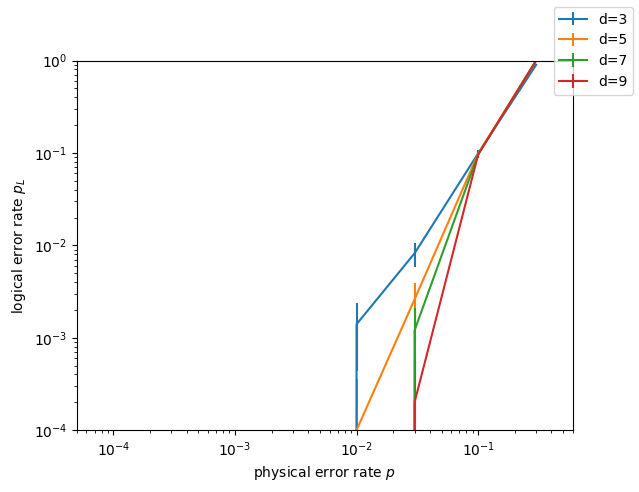

In [19]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import sinter

d_vec = [3, 5, 7, 9]
p_vec = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
jobs = [
    MonteCarloJob(d=d, p=p) for d in d_vec for p in p_vec
]

executor = MonteCarloJobExecutor(
    client,
    mock_logical_error_rate,
    jobs
)

def naive_next_job(executor: MonteCarloJobExecutor) -> tuple[MonteCarloJob, int] | None:
    for job in executor:
        if job.expecting_shots < 1000:
            return job, 10000 - job.expecting_shots

hdisplay = display.display("", display_id=True)

def plot_intermediate_result(executor: MonteCarloJobExecutor):
    fig, ax = plt.subplots(1,1)
    ax.clear()
    ax.set_xlabel('physical error rate $p$')
    ax.set_ylabel('logical error rate $p_L$')
    ax.set_xlim(min(p_vec) / 2, max(p_vec) * 2)
    ax.set_xscale("log")
    ax.set_ylim(1e-4, 1)
    ax.set_yscale("log")
    for d in d_vec:
        x_vec = []
        y_vec = []
        err_vec = []
        for p in p_vec:
            job = executor.get_job(d=d, p=p)
            if job is None or job.result is None:
                continue
            x_vec.append(p)
            stats = job.result.stats_of(job)
            y_vec.append(stats.failure_rate_value)
            err_vec.append(stats.failure_rate_uncertainty)
        ax.errorbar(x_vec, y_vec, err_vec, label=f"d={d}")
    fig.legend()
    hdisplay.update(fig)
    plt.close(fig)

executor.execute(naive_next_job, loop_callback=plot_intermediate_result)

In [11]:
from concurrent.futures import Future

future = Future()
future.set_result(0)
future.done()


True

In [12]:
future = Future()
future.done()

False

## Useful Resources

- https://docs.dask.org/en/stable/deploying.html
- https://docs.dask.org/en/stable/futures.html
- https://docs.ycrc.yale.edu/clusters-at-yale/access/ood-jupyter/


In [13]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(
    queue='regular',
    account="myaccount",
    cores=24,
    memory="500 GB"
)
cluster.scale(jobs=10)  # ask for 10 jobs

ModuleNotFoundError: No module named 'dask_jobqueue'